In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

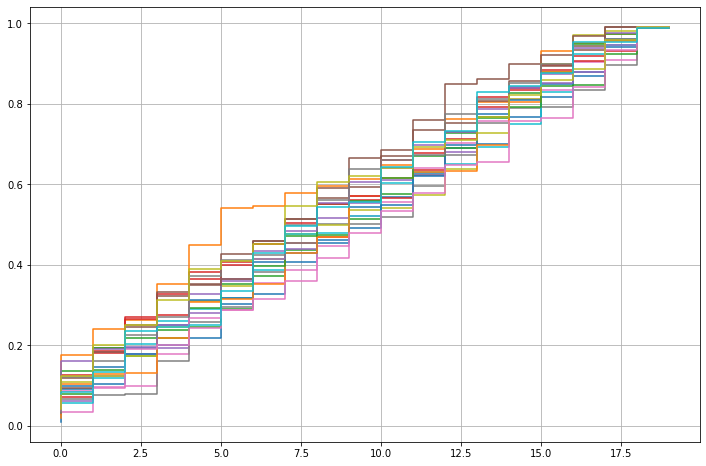

In [14]:
# First try
K = 20

plt.figure(figsize=(12, 8), facecolor='white')

for _ in range(20):
    x = np.random.random(K)
    plt.step(np.arange(K), np.cumsum(x)/(x.sum()+1e-1))

plt.grid(True)
plt.show()

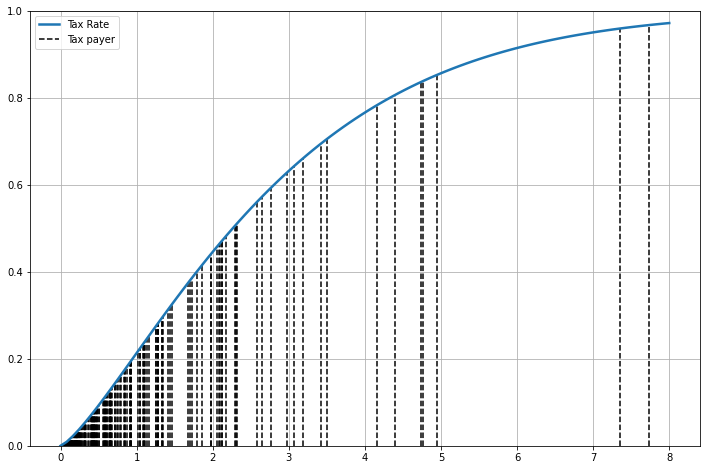

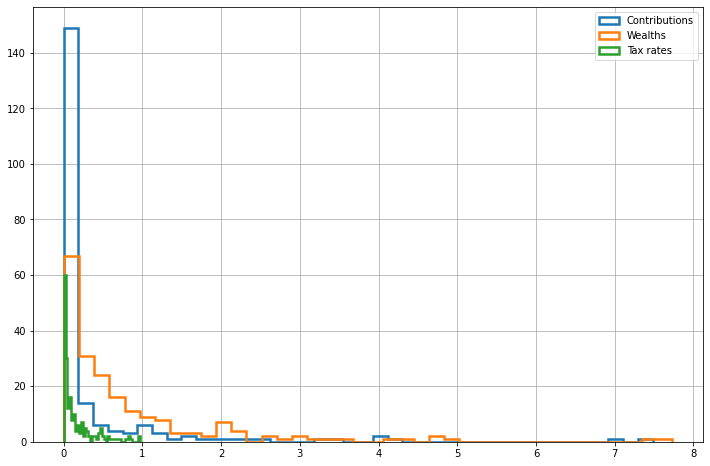

In [4]:

np.random.seed(42)

# Second try - Weibull CDF
def weibull_cdf(x, l, k):
    return 1 - np.exp(-(x/l)**k)

N = 200
n_tax_bins = 100
bins = np.linspace(0, 8, n_tax_bins)
tax_rates = weibull_cdf(bins, 3, 1.3)
wealths = np.random.pareto(2, N)

plt.figure(facecolor='white', figsize=(12, 8))
plt.plot(bins, weibull_cdf(bins, 3, 1.3), linewidth=2.5, label='Tax Rate')
plt.vlines(wealths, 0, weibull_cdf(wealths, 3, 1.3), colors='k', linestyles='--', label='Tax payer')
plt.grid(True)
plt.legend()
plt.ylim([0, 1.0])

plt.figure(facecolor='white', figsize=(12, 8))
plt.hist(wealths * weibull_cdf(wealths, 3, 1.3), bins=40, histtype='step', label='Contributions', linewidth=2.5)
plt.hist(wealths, bins=40, histtype='step', label='Wealths', linewidth=2.5)
plt.hist(weibull_cdf(wealths, 3, 1.3), bins=40, histtype='step', label='Tax rates', linewidth=2.5)
plt.grid(True)
plt.legend()
    

In [57]:
def save_results(T = 20, N = 100):
    r = np.zeros((T, N))
    s = np.zeros(T)
    w = np.zeros(T)
    income_propensity = np.random.pareto(2, N)
    incomes = np.min(np.random.normal(income_propensity, 0.2 * income_propensity), 0) + 1e-3
    for t in range(T):
        incomes += np.random.normal(income_propensity, 0.2 * income_propensity)
        contrib = weibull_cdf(incomes, 3, 1.3)
        w = contrib / contrib.sum()
        net_income = contrib.sum()/N - contrib
        incomes += net_income
        negative_transfers = net_income[net_income < 0].sum()
        r[t] = incomes
        s[t] = negative_transfers

    return r, s

r, s = save_results(100, 50)

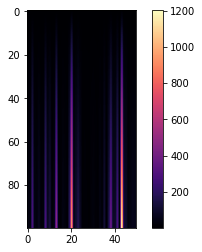

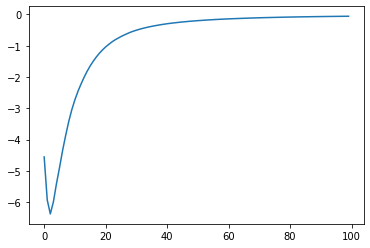

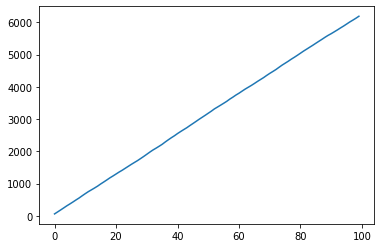

In [59]:
plt.imshow(r, cmap='magma')
plt.colorbar()

plt.figure()
plt.plot(s, label='demo transfer')

plt.figure()
plt.plot(r.sum(1), label='demo total wealth')

## Experiment 1 with votes on the change of tax structure

In [5]:
def plots(r, s, votes, tax_rates, proposed_tax_rates):
    plt.figure(figsize=(12, 8), facecolor='white')
    plt.imshow(r, cmap='magma')
    plt.colorbar()

    plt.figure(figsize=(12, 8), facecolor='white')
    plt.plot(s, linewidth=2.5, label='Total transfer')
    plt.grid(True)
    plt.legend()

    plt.figure(figsize=(12, 8), facecolor='white')
    plt.plot(r.sum(1), linewidth=2.5, label='Total wealth')
    plt.grid(True)
    plt.legend()

    plt.figure(figsize=(12, 8), facecolor='white')
    plt.plot(votes, linewidth=2.5, label='Votes')
    plt.grid(True)
    plt.legend()

    plt.figure(figsize=(12, 8), facecolor='white')
    # plt.scatter(tax_rates[:, 0], tax_rates[:, 1], label='Tax rates', marker='^', linestyle='--', edgecolor='k', c=np.linspace(0, 1, tax_rates.shape[0]))
    plt.plot(proposed_tax_rates[:, 0], proposed_tax_rates[:, 1], label='Proposed tax rates', 
                    linestyle='--', linewidth=0.5, c="C1")
    plt.plot(tax_rates[:, 0], tax_rates[:, 1], c="C0", label='Tax rates', marker='o', markerfacecolor='red', linewidth=2.5)
    plt.grid(True)
    plt.legend()


def save_results(T = 20, N = 100, meritocracy=False):
    r = np.zeros((T, N))
    s = np.zeros(T)
    votes = np.zeros(T)
    tax_rates = np.zeros((T, 2))
    proposed_tax_rates = np.zeros((T, 2))
    income_propensity = np.random.pareto(2, N)
    incomes = np.maximum(np.random.normal(income_propensity, 0.2 * income_propensity), 1e-3)
    current_tax_rate = (10, 1)
    
    for t in range(T):
        # Propose new tax rate, to start from next iteration
        proposed_tax_rate = current_tax_rate + np.random.normal(0, 1, 2)
        proposed_tax_rate = np.maximum(proposed_tax_rate, 1e-3)

        # Add income from labour
        labour_income = np.random.normal(income_propensity, 0.2 * income_propensity)
        incomes += labour_income
        
        # Contribution calculated using proposed tax rates
        hypothetical_contrib = labour_income * weibull_cdf(labour_income, proposed_tax_rate[0], proposed_tax_rate[1])

        # Hypothetical benefit
        hypothetical_net_income = hypothetical_contrib.sum()/N - hypothetical_contrib
        
        # Contribution calculated using current tax rates
        contrib = labour_income * weibull_cdf(labour_income, current_tax_rate[0], current_tax_rate[1])
        
        # Real benefit
        net_income = contrib.sum()/N - contrib

        # Individual votes
        v = hypothetical_net_income > net_income

        # Weights using current contributions
        if meritocracy == True:
            w = contrib / contrib.sum()
        else:
            w = np.ones(N)/N
        
        # Vote outcome
        V = (w * v).sum() / w.sum() > 0.5
        
        # Add distribution income to your income
        incomes += net_income
        
        # Compute negative transfers
        negative_transfers = np.abs(net_income[net_income < 0].sum())
        # money_sink = net_income[net_income < 0].sum()

        r[t] = incomes
        s[t] = negative_transfers
        votes[t] = V
        tax_rates[t] = current_tax_rate
        proposed_tax_rates[t] = proposed_tax_rate

        # If vote accepted, change tax rate
        if V:
            current_tax_rate = proposed_tax_rate

    return r, s, votes, tax_rates, proposed_tax_rates

Shapes (500,) (500,)
Shapes (500,) (500,)


/tmp/ipykernel_190/3988902680.py:67: RuntimeWarning: invalid value encountered in true_divide
  w = contrib / contrib.sum()


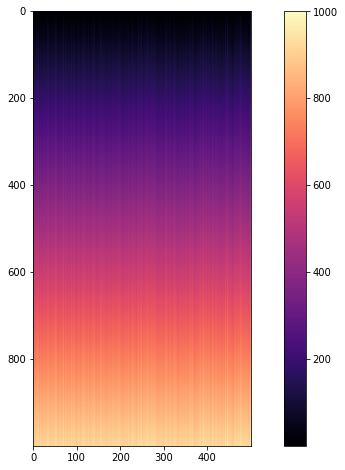

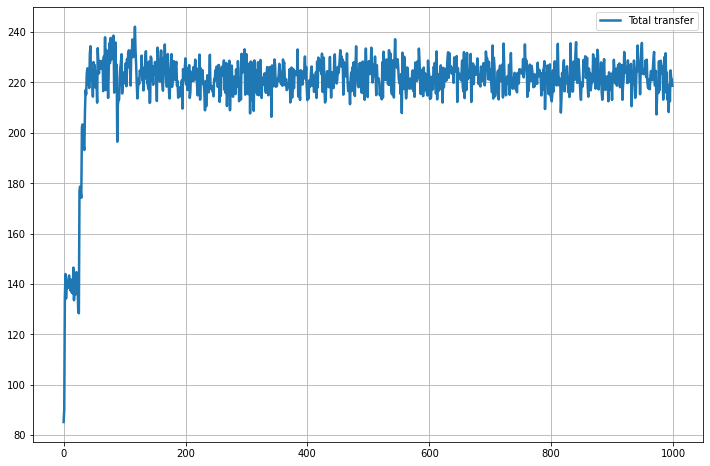

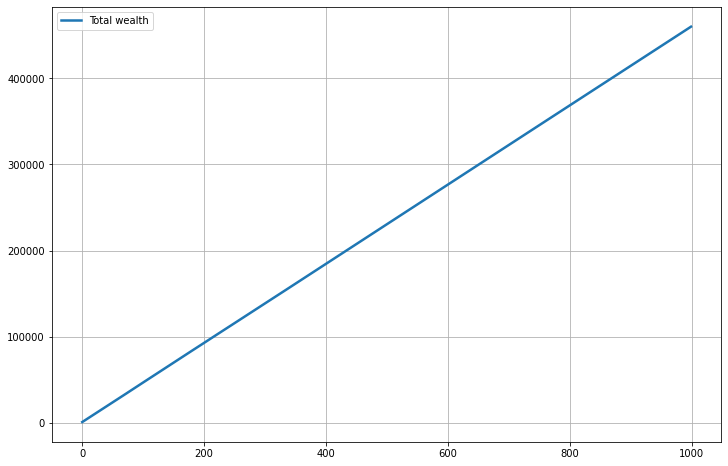

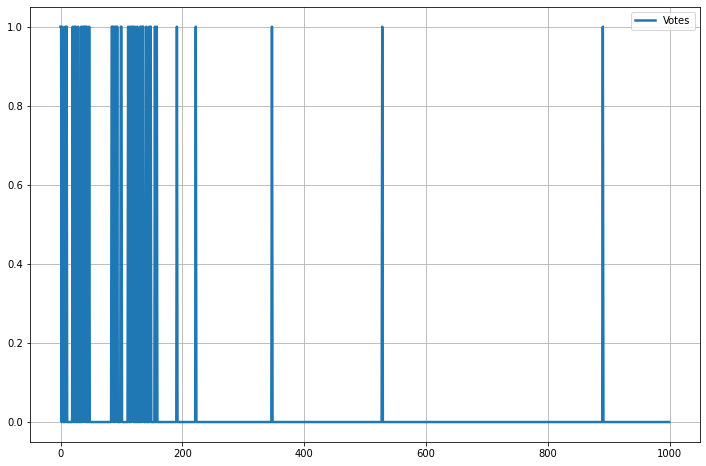

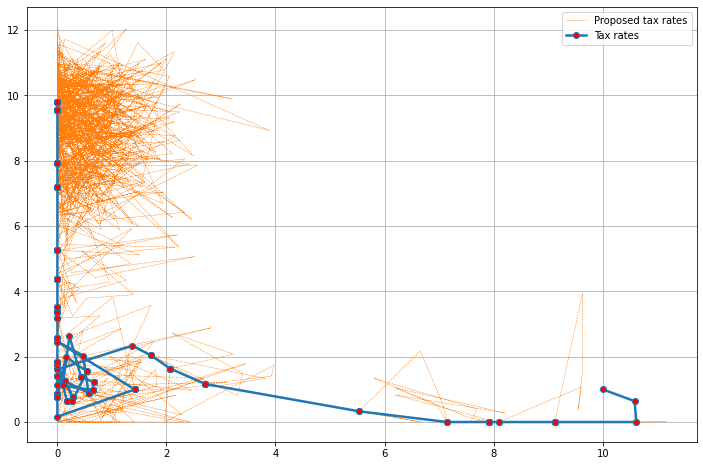

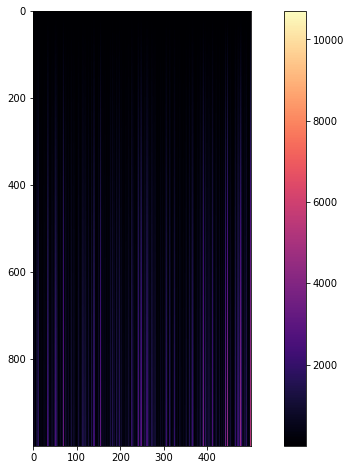

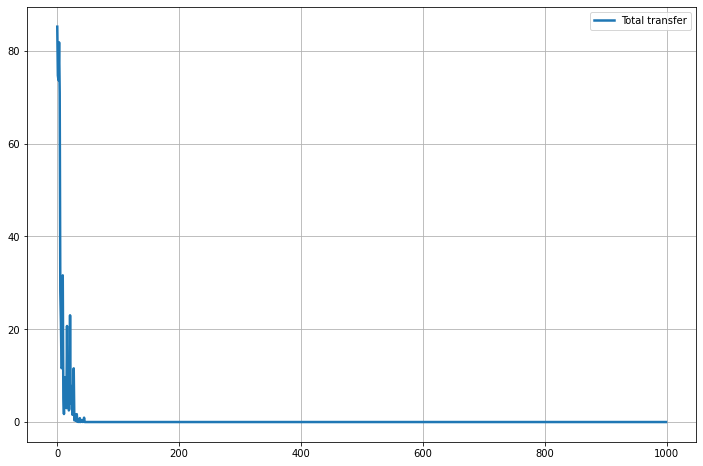

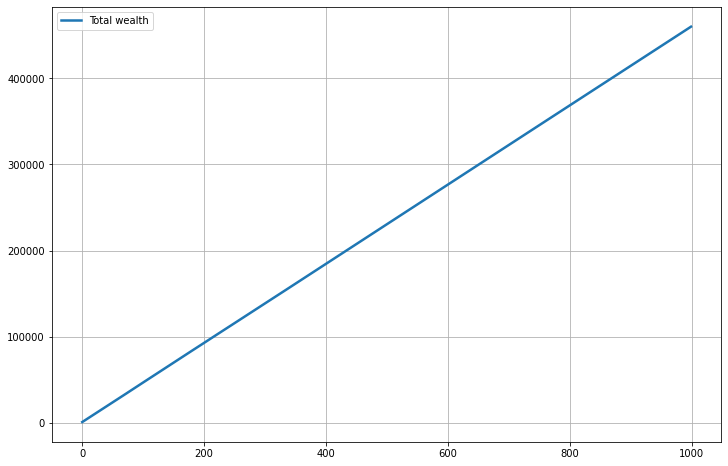

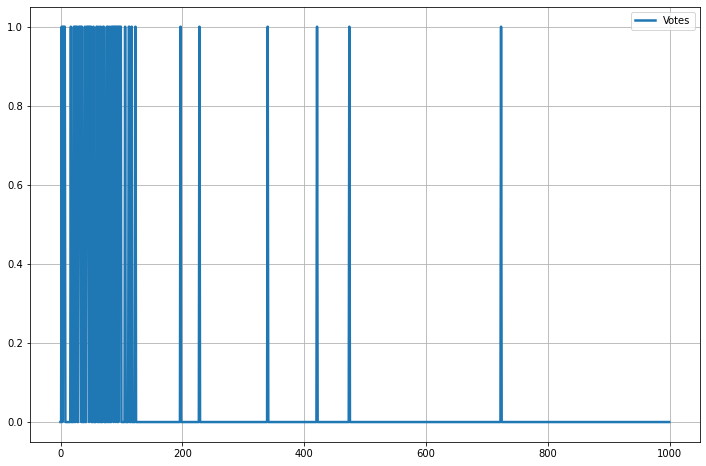

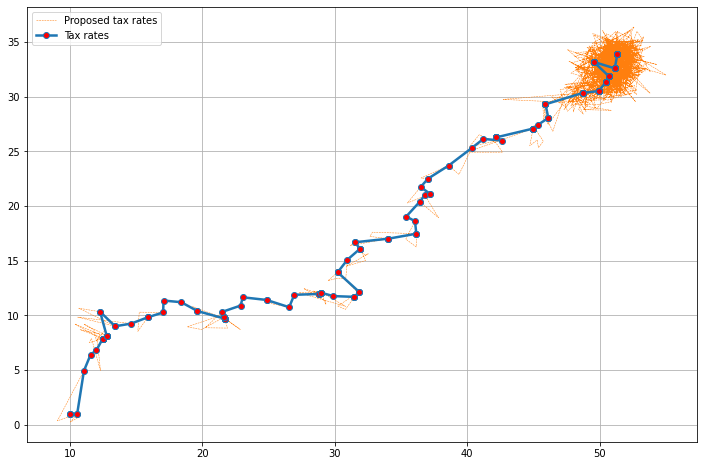

In [9]:
np.random.seed(42)
r, s, votes, tax_rates, proposed_tax_rates = save_results(1000, 500, meritocracy=False)
np.random.seed(42)
r2, s2, votes2, tax_rates2, proposed_tax_rates2 = save_results(1000, 500, meritocracy=True)

plots(r, s, votes, tax_rates, proposed_tax_rates)
plots(r2, s2, votes2, tax_rates2, proposed_tax_rates2)


## Results
- As $T \rightarrow \infty$, in the meritocratic case, we reach zero taxation, a free society.
- As $T \rightarrow \infty$, in the democratic case, we reach 100% taxation, or uniform division of all contributions - a communist society.